# Demo of an MLP neural network Leo transpilation - MNIST dataset

MLP neural networks are expressive ML models. Here, we use them for the MNIST classification task, which contains images of handwritten digits. We show the inference of MLP neural networks for the MNIST dataset is possible in a zero knowledge environment.

For this, we first download the dataset, and then compute feature representations of the dataset. We then train and test an MLP neural network on the feature dataset. Afterward, we iteratively prune the network (meaning we set weights and biases close to 0 to actually 0) and fine-tune it. Then, we transpile the final MLP neural network to Leo, evaluate the Leo network and create a zero knowledge proof.

## Define function to download the dataset

In [1]:
import gzip
import os
import shutil

import requests


def download_and_extract_dataset(url, save_path, folder_path):
    """Download and extract dataset if it doesn't exist."""
    if not os.path.exists(save_path):
        print(f"Downloading {os.path.basename(save_path)}...")
        response = requests.get(url)
        with open(save_path, "wb") as file:
            file.write(response.content)

        decompressed_file_name = os.path.splitext(os.path.basename(save_path))[0]
        decompressed_file_path = os.path.join(folder_path, decompressed_file_name)

        with gzip.open(save_path, "rb") as f_in:
            with open(decompressed_file_path, "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)

        print(f"{decompressed_file_name} downloaded and extracted.")
    else:
        print(f"{os.path.basename(save_path)} already exists.")

## Download the dataset

In [2]:
# URLs and filenames
file_info = [
    (
        "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
        "train-images-idx3-ubyte.gz",
    ),
    (
        "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
        "train-labels-idx1-ubyte.gz",
    ),
    (
        "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
        "t10k-images-idx3-ubyte.gz",
    ),
    (
        "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz",
        "t10k-labels-idx1-ubyte.gz",
    ),
]

folder_name = "tmp/mnist"
folder_path = os.path.join(os.getcwd(), folder_name)

os.makedirs(folder_path, exist_ok=True)  # Create folder if it doesn't exist

# Download and extract each file
for url, file_name in file_info:
    path_to_save = os.path.join(folder_path, file_name)
    download_and_extract_dataset(url, path_to_save, folder_path)

train-images-idx3-ubyte.gz already exists.
train-labels-idx1-ubyte.gz already exists.
t10k-images-idx3-ubyte.gz already exists.
t10k-labels-idx1-ubyte.gz already exists.


## Define function to read the dataset

In [3]:
import numpy as np


def read_idx3_ubyte_image_file(filename):
    """Read IDX3-ubyte formatted image data."""
    with open(filename, "rb") as f:
        magic_num = int.from_bytes(f.read(4), byteorder="big")
        num_images = int.from_bytes(f.read(4), byteorder="big")
        num_rows = int.from_bytes(f.read(4), byteorder="big")
        num_cols = int.from_bytes(f.read(4), byteorder="big")

        if magic_num != 2051:
            raise ValueError(f"Invalid magic number: {magic_num}")

        images = np.zeros((num_images, num_rows, num_cols), dtype=np.uint8)

        for i in range(num_images):
            for r in range(num_rows):
                for c in range(num_cols):
                    pixel = int.from_bytes(f.read(1), byteorder="big")
                    images[i, r, c] = pixel

    return images


def read_idx1_ubyte_label_file(filename):
    """Read IDX1-ubyte formatted label data."""
    with open(filename, "rb") as f:
        magic_num = int.from_bytes(f.read(4), byteorder="big")
        num_labels = int.from_bytes(f.read(4), byteorder="big")

        if magic_num != 2049:
            raise ValueError(f"Invalid magic number: {magic_num}")

        labels = np.zeros(num_labels, dtype=np.uint8)

        for i in range(num_labels):
            labels[i] = int.from_bytes(f.read(1), byteorder="big")

    return labels

## Read the dataset

In [4]:
folder_path = os.path.join(
    os.getcwd(), folder_name
)  # Adjust this path to where you stored the files

train_images = read_idx3_ubyte_image_file(
    os.path.join(folder_path, "train-images-idx3-ubyte")
)
train_labels = read_idx1_ubyte_label_file(
    os.path.join(folder_path, "train-labels-idx1-ubyte")
)
test_images = read_idx3_ubyte_image_file(
    os.path.join(folder_path, "t10k-images-idx3-ubyte")
)
test_labels = read_idx1_ubyte_label_file(
    os.path.join(folder_path, "t10k-labels-idx1-ubyte")
)

print(
    f"Shape of train_images: {train_images.shape}"
)  # Should output "Shape of train_images: (60000, 28, 28)"
print(
    f"Shape of train_labels: {train_labels.shape}"
)  # Should output "Shape of train_labels: (60000,)"
print(
    f"Shape of test_images: {test_images.shape}"
)  # Should output "Shape of test_images: (10000, 28, 28)"
print(
    f"Shape of test_labels: {test_labels.shape}"
)  # Should output "Shape of test_labels: (10000,)"

Shape of train_images: (60000, 28, 28)
Shape of train_labels: (60000,)
Shape of test_images: (10000, 28, 28)
Shape of test_labels: (10000,)


## Convert the datasets to PyTorch tensors, and get a validation set
(We use PyTorch instead of sci-kit learn to train sparse neural networks with L1 regularization)

In [5]:
# conver to pytorch tensors
import torch

train_images_tensor_initial = torch.from_numpy(train_images).float()
train_labels_tensor_initial = torch.from_numpy(train_labels).long()
test_images_tensor = torch.from_numpy(test_images).float()
test_labels_tensor = torch.from_numpy(test_labels).long()

# seed the random number generator
torch.manual_seed(0)

# shuffle the training dataset
indices = torch.randperm(train_images_tensor_initial.shape[0])
train_images_tensor_shuffled = train_images_tensor_initial[indices]
train_labels_tensor_shuffled = train_labels_tensor_initial[indices]

# get a 10% validation set
validation_size = int(train_images_tensor_shuffled.shape[0] * 0.1)
validation_images_tensor = train_images_tensor_shuffled[:validation_size]
validation_labels_tensor = train_labels_tensor_shuffled[:validation_size]
train_images_tensor = train_images_tensor_shuffled[validation_size:]
train_labels_tensor = train_labels_tensor_shuffled[validation_size:]

In [6]:
print("Train labels tensor shape:", train_labels_tensor.shape)
print("Validation labels tensor shape:", validation_labels_tensor.shape)
print("Test labels tensor shape:", test_labels_tensor.shape)

Train labels tensor shape: torch.Size([54000])
Validation labels tensor shape: torch.Size([6000])
Test labels tensor shape: torch.Size([10000])


## Extract feature representations of the dataset

(We transform the bounding box images to 12x12 images, defined by the new_size variable. There is a trade-off in circuit constraints and ML model accuracy. You can increase the image size which will lead to a higher accuracy at the cost of more circuit constraints and thus longer proving times.)

In [7]:
import numpy as np


def get_bounding_box(img):
    """
    Extract the bounding box from an MNIST image.

    Args:
        img (np.ndarray): 2D numpy array representing the MNIST image.

    Returns:
        (np.ndarray): Cropped image with the bounding box.
    """

    # convert torch image to numpy array
    img = img.numpy()

    # Find the rows and columns where the image has non-zero pixels
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)

    # Find the first and last row and column indices where the image has non-zero pixels
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    # Return the cropped image
    return img[rmin : rmax + 1, cmin : cmax + 1]

In [8]:
import cv2


def get_resized_datasets(
    train_images_tensor, validation_images_tensor, test_images_tensor, new_size
):
    num_train = len(train_images_tensor)
    num_test = len(test_images_tensor)
    num_val = len(validation_images_tensor)

    train_images_tensor_resized = np.zeros((num_train, new_size**2))
    validation_images_tensor_resized = np.zeros((num_val, new_size**2))
    test_images_tensor_resized = np.zeros((num_test, new_size**2))

    for i in range(num_train):
        cropped_image = get_bounding_box(train_images_tensor[i].reshape(28, 28))
        cropped_image_uint8 = np.clip(cropped_image, 0, 255).astype(np.uint8)
        resized_image = cv2.resize(
            cropped_image_uint8, (new_size, new_size), interpolation=cv2.INTER_AREA
        )
        train_images_tensor_resized[i, :] = resized_image.flatten()

    for i in range(num_val):
        cropped_image = get_bounding_box(validation_images_tensor[i].reshape(28, 28))
        cropped_image_uint8 = np.clip(cropped_image, 0, 255).astype(np.uint8)
        resized_image = cv2.resize(
            cropped_image_uint8, (new_size, new_size), interpolation=cv2.INTER_AREA
        )
        validation_images_tensor_resized[i, :] = resized_image.flatten()

    for i in range(num_test):
        cropped_image = get_bounding_box(test_images_tensor[i].reshape(28, 28))
        cropped_image_uint8 = np.clip(cropped_image, 0, 255).astype(np.uint8)
        resized_image = cv2.resize(
            cropped_image_uint8, (new_size, new_size), interpolation=cv2.INTER_AREA
        )
        test_images_tensor_resized[i, :] = resized_image.flatten()

    return (
        train_images_tensor_resized,
        validation_images_tensor_resized,
        test_images_tensor_resized,
    )

In [9]:
new_size = 12
train_images_resized, val_images_resized, test_images_resized = get_resized_datasets(
    train_images_tensor, validation_images_tensor, test_images_tensor, new_size
)

## Let's compute the features

In [10]:
def compute_haar_features(image):
    # raise value error if the image is not square
    if image.shape[0] != image.shape[1]:
        raise ValueError("The input image must be square.")

    features = []

    # Sliding window
    for i in range(0, image.shape[0], 3):  # Slide vertically with a step of 3
        for j in range(0, image.shape[0], 3):  # Slide horizontally with a step of 3

            if i + 6 > image.shape[0] or j + 6 > image.shape[0]:
                continue

            # Extract 6x6 window
            window = image[i : i + 6, j : j + 6]

            # Horizontal feature
            horizontal_feature_value = np.sum(window[0:3, :]) - np.sum(window[3:6, :])

            # Vertical feature
            vertical_feature_value = np.sum(window[:, 0:3]) - np.sum(window[:, 3:6])

            features.append(horizontal_feature_value)
            features.append(vertical_feature_value)

    return np.array(features)


def aspect_ratio(image, threshold=0.5):
    # Threshold the image to create a binary representation
    bin_image = image > threshold
    # Find the bounding box
    row_indices, col_indices = np.nonzero(bin_image)
    max_row, min_row = np.max(row_indices), np.min(row_indices)
    max_col, min_col = np.max(col_indices), np.min(col_indices)

    # Calculate the aspect ratio of the bounding box
    width = max_col - min_col + 1
    height = max_row - min_row + 1

    if height == 0:  # To avoid division by zero
        return 1.0

    return width / height


from scipy.ndimage import label


def num_regions_below_threshold(image, threshold=0.5):
    # Threshold the image so that pixels below the threshold are set to 1
    # and those above the threshold are set to 0.
    bin_image = image < threshold

    # Use connected components labeling
    labeled_array, num_features = label(bin_image)

    # Return the number of unique regions
    # (subtracting 1 as one of the labels will be the background)
    return num_features

In [11]:
# compute datasets

num_train = len(train_images_tensor)
num_val = len(validation_images_tensor)
num_test = len(test_images_tensor)

aspect_ratio_train = np.zeros(num_train)
aspect_ratio_val = np.zeros(num_val)
aspect_ratio_test = np.zeros(num_test)

num_white_regions_train = np.zeros(num_train)
num_white_regions_val = np.zeros(num_val)
num_white_regions_test = np.zeros(num_test)

haar_1 = compute_haar_features(train_images_resized[0].reshape(new_size, new_size))
len_haar_features = len(haar_1)

haar_train = np.zeros((num_train, len_haar_features))
haar_val = np.zeros((num_val, len_haar_features))
haar_test = np.zeros((num_test, len_haar_features))

for i in range(num_train):
    aspect_ratio_train[i] = aspect_ratio(train_images_tensor[i].reshape(28, 28).numpy())
    num_white_regions_train[i] = num_regions_below_threshold(
        train_images_tensor[i].reshape(28, 28)
    )
    haar_train[i, :] = compute_haar_features(
        train_images_resized[i, :].reshape(new_size, new_size)
    )

for i in range(num_val):
    aspect_ratio_val[i] = aspect_ratio(
        validation_images_tensor[i].reshape(28, 28).numpy()
    )
    num_white_regions_val[i] = num_regions_below_threshold(
        validation_images_tensor[i].reshape(28, 28)
    )
    haar_val[i, :] = compute_haar_features(
        val_images_resized[i, :].reshape(new_size, new_size)
    )

for i in range(num_test):
    aspect_ratio_test[i] = aspect_ratio(test_images_tensor[i].reshape(28, 28).numpy())
    num_white_regions_test[i] = num_regions_below_threshold(
        test_images_tensor[i].reshape(28, 28)
    )
    haar_test[i, :] = compute_haar_features(
        test_images_resized[i, :].reshape(new_size, new_size)
    )

## Take a look at the images, and the computed features

Original image


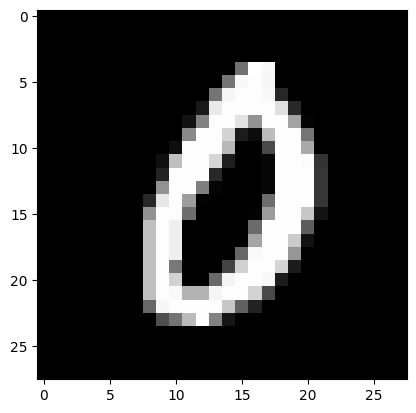

Image shape torch.Size([28, 28])
Label tensor(0)
Resized image


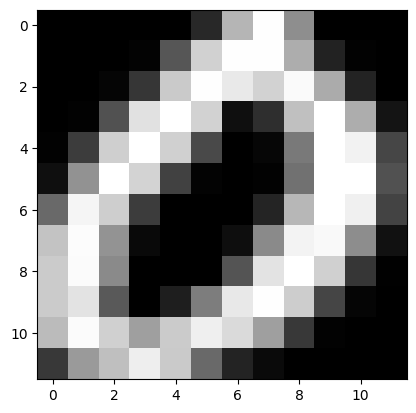

Image shape (12, 12)
Haar features: [-1413. -1567.   789.   -89.    88.   590.   461.   929.   743.  -101.
  -311. -1153. -1046.  1922. -1208.  -974.  1161.  1035.]
Shape of Haar features: (18,)
Aspect ratio: 0.7
Number of white regions: 2.0


In [12]:
image_id = 0

image = train_images_tensor[image_id].reshape(28, 28)

print("Original image")

import matplotlib.pyplot as plt

plt.imshow(image, cmap="gray")
plt.show()

print("Image shape", image.shape)
print("Label", train_labels_tensor[image_id])

print("Resized image")

image_resized = train_images_resized[image_id].reshape(new_size, new_size)

plt.imshow(image_resized, cmap="gray")
plt.show()

print("Image shape", image_resized.shape)

print("Haar features:", haar_train[image_id, :])
print("Shape of Haar features:", haar_train[image_id, :].shape)

print("Aspect ratio:", aspect_ratio_train[image_id])
print("Number of white regions:", num_white_regions_train[image_id])

## Let's merge all features into one dataset

In [13]:
# compute datasets

train_features = np.zeros((num_train, len_haar_features + 2))
val_features = np.zeros((num_val, len_haar_features + 2))
test_features = np.zeros((num_test, len_haar_features + 2))

for i in range(num_train):
    train_features[i, :] = np.hstack(
        (haar_train[i, :], aspect_ratio_train[i], num_white_regions_train[i])
    )

for i in range(num_val):
    val_features[i, :] = np.hstack(
        (haar_val[i, :], aspect_ratio_val[i], num_white_regions_val[i])
    )

for i in range(num_test):
    test_features[i, :] = np.hstack(
        (haar_test[i, :], aspect_ratio_test[i], num_white_regions_test[i])
    )

In [14]:
print("Shape of training features:", train_features.shape)
print("First training feature vector:", train_features[0, :])

Shape of training features: (54000, 20)
First training feature vector: [-1.413e+03 -1.567e+03  7.890e+02 -8.900e+01  8.800e+01  5.900e+02
  4.610e+02  9.290e+02  7.430e+02 -1.010e+02 -3.110e+02 -1.153e+03
 -1.046e+03  1.922e+03 -1.208e+03 -9.740e+02  1.161e+03  1.035e+03
  7.000e-01  2.000e+00]


## Normalize the dataset

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_features_normalized = torch.tensor(scaler.fit_transform(train_features)).float()
val_features_normalized = torch.tensor(scaler.transform(val_features)).float()
test_features_normalized = torch.tensor(scaler.transform(test_features)).float()

In [16]:
print("First training feature vector (normalized):", train_features_normalized[0, :])

First training feature vector (normalized): tensor([-1.2143, -0.8321,  0.4906,  0.1937, -0.2191,  0.0082,  0.4311,  1.1292,
         0.6659,  0.1091, -0.3643, -1.2731, -0.6324,  2.4261, -0.8677, -0.8842,
         1.0577,  0.2177, -0.4527,  0.4035])


## Define the neural network and the training and test function

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score


def evaluate_model(model):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        test_outputs = model(test_features_normalized)
        _, predicted = torch.max(test_outputs.data, 1)
        accuracy = accuracy_score(test_labels, predicted.numpy())
        print("Accuracy:", accuracy)
        return accuracy


# Define the PyTorch neural network
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def train(model):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop with L1 regularization
    lambda_l1 = 0.0001  # L1 regularization coefficient

    validation_losses = []
    epoch = 0

    model_states = []

    while True:
        optimizer.zero_grad()
        outputs = model(train_features_normalized)

        loss = criterion(outputs, train_labels_tensor)

        # Add L1 regularization
        l1_reg = torch.tensor(0.0, requires_grad=True)
        for param in model.parameters():
            l1_reg = l1_reg + torch.norm(param, 1)
        loss += lambda_l1 * l1_reg

        loss.backward()
        optimizer.step()

        # Print progress
        if (epoch + 1) % 100 == 0:
            print(
                f"Epoch [{epoch + 1}], Loss: {loss.item():.4f}, validation loss: {validation_losses[-1]:.4f}"
            )

        # store model state
        model_states.append(model.state_dict())

        # Compute validation loss
        with torch.no_grad():
            outputs = model(val_features_normalized)
            loss = criterion(outputs, validation_labels_tensor)
            validation_losses.append(loss.item())

        # Check for early stopping if no improvement in validation loss in last 10 epochs
        if epoch > 10 and validation_losses[-1] > validation_losses[-10]:
            print("Early stopping")
            break

        epoch += 1

    best_model_state = model_states[np.argmin(validation_losses)]
    model.load_state_dict(best_model_state)
    validation_loss_of_best_model = validation_losses[np.argmin(validation_losses)]

    return model, epoch, validation_loss_of_best_model

## Let's create and train a model

In [18]:
# Hyperparameters
input_dim = train_features_normalized.shape[1]
output_dim = len(set(train_labels))  # Assuming train_labels are class indices
hidden_dim = (input_dim + output_dim) // 2

# Instantiate the model
model = SimpleNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

In [19]:
# Train the model
model, epochs, val_loss = train(model)

Epoch [100], Loss: 1.6674, validation loss: 1.6664
Epoch [200], Loss: 0.9882, validation loss: 0.9826
Epoch [300], Loss: 0.6444, validation loss: 0.6358
Epoch [400], Loss: 0.4973, validation loss: 0.4875
Epoch [500], Loss: 0.4247, validation loss: 0.4148
Epoch [600], Loss: 0.3842, validation loss: 0.3740
Epoch [700], Loss: 0.3591, validation loss: 0.3488
Epoch [800], Loss: 0.3424, validation loss: 0.3318
Epoch [900], Loss: 0.3305, validation loss: 0.3197
Epoch [1000], Loss: 0.3217, validation loss: 0.3106
Epoch [1100], Loss: 0.3146, validation loss: 0.3035
Epoch [1200], Loss: 0.3087, validation loss: 0.2977
Epoch [1300], Loss: 0.3038, validation loss: 0.2929
Epoch [1400], Loss: 0.2994, validation loss: 0.2887
Epoch [1500], Loss: 0.2955, validation loss: 0.2850
Epoch [1600], Loss: 0.2918, validation loss: 0.2816
Epoch [1700], Loss: 0.2883, validation loss: 0.2783
Epoch [1800], Loss: 0.2848, validation loss: 0.2751
Epoch [1900], Loss: 0.2814, validation loss: 0.2717
Epoch [2000], Loss: 0

In [20]:
evaluate_model(model)

Accuracy: 0.938


0.938

## Let's prune the model

In [21]:
def prune_pytorch_network(
    model, weight_threshold=1e-1, bias_threshold=1e-1
):  # noqa: D103
    num_weights = 0
    num_weights_already_zero = 0
    num_changed_weights = 0
    num_biases = 0
    num_biases_already_zero = 0
    num_changed_biases = 0

    # Pruning the weights
    for name, param in model.named_parameters():
        if "weight" in name:
            flattened_weights = param.data.view(-1)
            for j, weight in enumerate(flattened_weights):
                if weight == 0:
                    num_weights_already_zero += 1
                elif abs(weight) < weight_threshold:
                    flattened_weights[j] = 0
                    num_changed_weights += 1
                num_weights += 1
            param.data = flattened_weights.view(param.data.shape)
        elif "bias" in name:
            flattened_biases = param.data.view(-1)
            for j, bias in enumerate(flattened_biases):
                if bias == 0:
                    num_biases_already_zero += 1
                elif abs(bias) < bias_threshold:
                    flattened_biases[j] = 0
                    num_changed_biases += 1
                num_biases += 1
            param.data = flattened_biases.view(param.data.shape)

    # Set gradients of pruned weights to zero
    def zero_gradients_hook(grad):
        return grad * (grad != 0)

    hooks = []
    for name, param in model.named_parameters():
        if "weight" in name or "bias" in name:
            hooks.append(param.register_hook(zero_gradients_hook))

    print(f"Number of weight parameters: {num_weights}")  # noqa: T201
    print(f"Number of weights already zero: {num_weights_already_zero}")  # noqa: T201
    print(f"Number of changed weight parameters: {num_changed_weights}")  # noqa: T201
    print(f"Number of bias parameters: {num_biases}")  # noqa: T201
    print(f"Number of biases already zero: {num_biases_already_zero}")  # noqa: T201
    print(f"Number of changed bias parameters: {num_changed_biases}")  # noqa: T201
    print(  # noqa: T201
        f"Percentage of weights pruned: {num_changed_weights / num_weights * 100:.2f}%"
    )
    print(  # noqa: T201
        f"Percentage of biases pruned: {num_changed_biases / num_biases * 100:.2f}%"
    )
    print(  # noqa: T201
        f"Remaining number of non-zero weights: {num_weights - num_changed_weights}"
    )
    print(  # noqa: T201
        f"Remaining number of non-zero biases: {num_biases - num_changed_biases}"
    )

    return model, hooks

In [22]:
import copy

model_pruned = copy.deepcopy(model)
model_pruned, hooks = prune_pytorch_network(model_pruned, 1e-1, 1e-1)

_ = evaluate_model(model_pruned)

Number of weight parameters: 450
Number of weights already zero: 0
Number of changed weight parameters: 103
Number of bias parameters: 25
Number of biases already zero: 0
Number of changed bias parameters: 4
Percentage of weights pruned: 22.89%
Percentage of biases pruned: 16.00%
Remaining number of non-zero weights: 347
Remaining number of non-zero biases: 21
Accuracy: 0.9377


## Let's have a loop of fine-tuning, pruning, and evaluating

In [23]:
i = 0
val_loss_new = val_loss
model_to_prune = copy.deepcopy(model)

while True:
    print(f"Iteration {i}")
    model_pruned = copy.deepcopy(model_to_prune)
    model_pruned, _ = prune_pytorch_network(model_pruned, 1e-1, 1e-1)
    val_loss_old = val_loss_new

    model_to_prune = copy.deepcopy(model_pruned)
    print("Now training")
    model_to_prune, _, val_loss_new = train(model_to_prune)

    if val_loss_new > val_loss_old:
        print("Early stopping")
        break

    i += 1

accuracy = evaluate_model(model_pruned)

Iteration 0
Number of weight parameters: 450
Number of weights already zero: 0
Number of changed weight parameters: 103
Number of bias parameters: 25
Number of biases already zero: 0
Number of changed bias parameters: 4
Percentage of weights pruned: 22.89%
Percentage of biases pruned: 16.00%
Remaining number of non-zero weights: 347
Remaining number of non-zero biases: 21
Now training
Epoch [100], Loss: 0.2208, validation loss: 0.2075
Epoch [200], Loss: 0.2198, validation loss: 0.2066
Epoch [300], Loss: 0.2190, validation loss: 0.2061
Epoch [400], Loss: 0.2181, validation loss: 0.2055
Early stopping
Iteration 1
Number of weight parameters: 450
Number of weights already zero: 0
Number of changed weight parameters: 112
Number of bias parameters: 25
Number of biases already zero: 0
Number of changed bias parameters: 3
Percentage of weights pruned: 24.89%
Percentage of biases pruned: 12.00%
Remaining number of non-zero weights: 338
Remaining number of non-zero biases: 22
Now training
Early

## Let's convert this model to a scikit-learn MLP model

In [24]:
from sklearn.neural_network import MLPClassifier


def pytorch_to_sklearn(pytorch_model):

    # Extract weights and biases from PyTorch model
    fc1_weight = pytorch_model.fc1.weight.data
    fc1_bias = pytorch_model.fc1.bias.data
    fc2_weight = pytorch_model.fc2.weight.data
    fc2_bias = pytorch_model.fc2.bias.data

    # Get the sizes for initialization
    input_size = fc1_weight.shape[1]
    hidden_size = fc1_weight.shape[0]
    output_size = fc2_weight.shape[0]

    # Initialize sklearn MLP
    sklearn_mlp = MLPClassifier(
        hidden_layer_sizes=(hidden_size,), activation="relu", max_iter=1
    )

    # To ensure the model doesn't change the weights during the dummy fit, we set warm_start=True
    sklearn_mlp.warm_start = True

    # Dummy fit to initialize weights (necessary step before setting the weights)
    sklearn_mlp.fit(np.zeros((output_size, input_size)), list(range(output_size)))

    # Set the weights and biases
    sklearn_mlp.coefs_[0] = fc1_weight.t().numpy()
    sklearn_mlp.intercepts_[0] = fc1_bias.numpy()
    sklearn_mlp.coefs_[1] = fc2_weight.t().numpy()
    sklearn_mlp.intercepts_[1] = fc2_bias.numpy()

    return sklearn_mlp


# Convert the example PyTorch MLP to sklearn MLP
converted_model = pytorch_to_sklearn(model_pruned)

/Users/kp/miniconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


In [25]:
# Evaluate the sklearn model
accuracy = converted_model.score(test_features_normalized.numpy(), test_labels)
print("Accuracy:", accuracy)

layers_sizes = [converted_model.coefs_[0].shape[0]] + [
    coef.shape[1] for coef in converted_model.coefs_
]

print("Number of neurons per layer:", layers_sizes)

Accuracy: 0.9394
Number of neurons per layer: [20, 15, 10]


## Let's transpile this model to Leo

In [26]:
from zkml import LeoTranspiler

# Transpile the deceision tree into Leo code
print(type(converted_model))
lt = LeoTranspiler(
    model=converted_model, validation_data=train_features_normalized[0:600].numpy()
)
leo_project_path = os.path.join(os.getcwd(), "/tmp/mnist")
leo_project_name = "sklearn_mlp_mnist_1"
lt.to_leo(
    path=leo_project_path, project_name=leo_project_name, fixed_point_scaling_factor=16
)

# Compute the accuracy of the Leo program and the Python program on the test set
num_test_samples = len(test_features)

# let's limit the number of test stamples to 10 to make the computation faster
num_test_samples = min(num_test_samples, 50)

python_predictions = converted_model.predict(test_features)

leo_predictions = np.zeros(num_test_samples)
for i in range(num_test_samples):
    lc = lt.run(input=test_features[i])
    leo_predictions[i] = np.argmax(lc.output_decimal)

print(f"Constraints: {lc.circuit_constraints}")
print(f"Runtime for one instance: {lc.runtime} seconds")

leo_accuracy = (
    np.sum(leo_predictions[0:num_test_samples] == test_labels[0:num_test_samples])
    / num_test_samples
)
python_accuracy = (
    np.sum(python_predictions[0:num_test_samples] == test_labels[0:num_test_samples])
    / num_test_samples
)

print(f"Leo accuracy: {100*leo_accuracy} %")
print(f"Python accuracy: {100*python_accuracy} %")

<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
Constraints: 201491
Runtime for one instance: 1.7962210178375244 seconds
Leo accuracy: 74.0 %
Python accuracy: 74.0 %


## Let's generate a proof

In [27]:
zkp = lt.execute(input=test_features[0])

print(f"Constraints: {zkp.circuit_constraints}")
print(f"Runtime for one instance: {zkp.runtime} seconds\n")

print(f"Leo prediction: {zkp.output_decimal}")
print(f"Python prediction: {python_predictions[0]}")
print(f"True label: {test_labels[0]}\n")

print(f"Proof: {zkp.proof}")

Constraints: 201491
Runtime for one instance: 15.774071216583252 seconds

Leo prediction: [-2015.02587890625, -1571.911376953125, 1426.609130859375, 1412.776123046875, -8980.85546875, -2928.00244140625, -8780.64306640625, 5337.92138671875, 1679.63037109375, 271.654296875]
Python prediction: 7
True label: 7

Proof: proof1qqqsqqqqqqqqqqqpqqqqqqqqqqqy5xmjz74ut3c2uplnf7ych7jvf4zy8nunyq9t6pftrrgxegmrvn6s5s52k4rlq3j4qx03j0ddnpypqy46tmkdmxwggr7ycma9f6jynurpr8w0nv5n4eye3ztqpe5xuqkar236mnxdsqec4ahskelj9akrxqpr8puhzp25mjkh3uap9g25uu7helvz39an8tfaxqcclu64je8km9ht2nmyqgst4vcjl2yakwjdtzqydd078h04r67hh726u877zyujs5e0fnae8t0fqyjxrx98kxhgu7n4xykyar5e3w22npvhe2qg5dvqspru8ysug5zfk2xszaan80lxdj28cngzss8pd923d92r4avgywzkwuqk59vmsc55w6e3k9cp2f6sqdfj28ta3s4m5uf3vl6ehfuyxq4mpgrv5w0ktqs24xppfa8rywaelxsphwuummpl385ta9qexdcmq92f7gmch7w288l9ppht9sppare24w9mjqnmpshanq5txy3k4t4capgsdvcj04nlfu4zkscekwcfvqrymatqm9lyu0c3g8htzq9k5fzqsrzm24k5jnjmc6w03e5jejc9n0xv3l8c998nesshuvuz2z2gwzqs5mj3830xc42vv0hhg7wxcmyts7td65j3wg

Plot the image


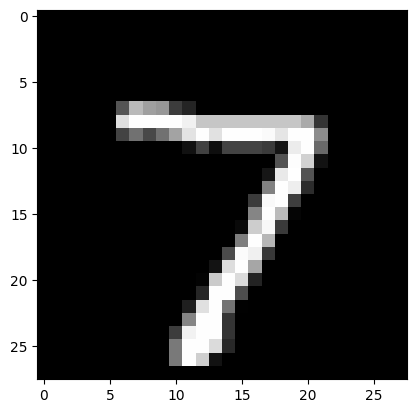

In [28]:
print("Plot the image")
plt.imshow(test_images_tensor[0].reshape(28, 28), cmap="gray")
plt.show()